In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

Downloading dataset

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

 95% 329M/346M [00:01<00:00, 225MB/s]
100% 346M/346M [00:01<00:00, 216MB/s]


In [ ]:
!unzip intel-image-classification  -d  dataset  

Streaming output truncated to the last 5000 lines.
  inflating: dataset/seg_train/seg_train/mountain/7506.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7537.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7539.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7551.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7560.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7565.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7578.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7581.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7586.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7647.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7652.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7654.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7662.jpg  
  inflating: dataset/seg_train/seg_train/mountain/767.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7672.jpg  
  inflating: dataset/seg_train/seg_

# Dataset and Dataloader

In [ ]:
train_dir = '/content/dataset/seg_train/seg_train'
test_dir = '/content/dataset/seg_test/seg_test'
BATCH_SIZE = 32

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      #  transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.4302, 0.4575, 0.4538],[0.2606, 0.2588, 0.2907],inplace = True)])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.4302, 0.4575, 0.4538],[0.2606, 0.2588, 0.2907],inplace = True)])


train_ds = datasets.ImageFolder(root=train_dir,transform=train_transforms)
test_ds = datasets.ImageFolder(root=test_dir,transform=test_transforms)

In [ ]:
train_loader = DataLoader(dataset = train_ds,batch_size = BATCH_SIZE,shuffle = True,num_workers=2,pin_memory=True)

test_loader = DataLoader(dataset = test_ds,batch_size = BATCH_SIZE,num_workers=2, pin_memory=True)

# Utility Functions

In [ ]:
def validation(model: torch.nn.modules.module,
               val_loader:torch.utils.data.dataloader,
               loss_fn: torch.nn.modules.loss) -> float:
  '''
  compute validation loss with corresponding model and loss function
  return validation loss
  '''

  model.eval()
  total_loss = 0 
  with torch.no_grad():
    for data, targets in tqdm(val_loader, desc= 'Validation'):
      data = data.to(device)
      targets = targets.to(device)

      scores = model(data)

      loss = loss_fn(scores,targets)
      total_loss += loss.item()
  model.train()
  return total_loss / len(val_loader)


In [ ]:
def training(model: torch.nn.modules.module,
             train_dataset: torch.utils.data.dataloader,
             val_dataset: torch.utils.data.dataloader,
             criterion: torch.nn.modules.loss,
             optimizer:torch.optim,
             epochs: int = 5) -> tuple:


  '''
  train model with given train set and optimizer
  return train and validation losses
  '''
  train_losses = []
  val_losses = []
  model.train()
  for epoch in tqdm(range(epochs) ):
    for  data, targets in tqdm(train_dataset,desc = f'Epoch {epoch + 1}'):
      # convert data and target to device
      data = data.to(device)
      targets = targets.to(device)

      # forward pass
      scores = model(data)
      loss = criterion(scores,targets)

      # backward pass
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()

    #validation
    val_loss = validation(model,val_dataset,criterion)
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    print(f'Train Loss: {np.mean(train_losses):.2f}, ',end = '')
    print(f'Validation Loss: {np.mean(val_losses):.2f}')

  return train_losses, val_losses

In [ ]:
def inference(model: torch.nn.modules.module,
              test_dataset: torch.utils.data.dataloader) -> float:

  '''
  inference model on test set
  return test accuracy
  '''

  n_samples = 0
  n_correct = 0
  model.eval()

  with torch.no_grad():
    for data, targets in tqdm(test_dataset):
      data = data.to(device)
      targets = targets.to(device)

      scores = model(data)
      _, preds = scores.max(1)
      n_correct += (preds == targets).sum().item()
      n_samples += targets.size(0)

    return n_correct / n_samples

In [ ]:
def print_acc(acc: float,train: bool=True)-> None:
  '''
  print accuracy in appropriate format
  '''
  if train:
    print(f"Train Accuracy: {acc * 100:.2f}%")
  else:
    print(f"Test Accuracy: {acc * 100:.2f}%")

In [ ]:
def plot(train_loss: list,val_loss: list) -> None:
  '''
  plotting train and validation losses
  '''
  epochs = list(range(1,len(train_loss)+1))

  plt.plot(epochs,train_loss,label = 'train loss')
  plt.plot(epochs,val_loss,label = 'validation loss')
  plt.xlabel('# epochs')
  plt.xticks(epochs)
  plt.ylabel('loss')
  plt.legend()
  # fig, ax = plt.subplots(1,2,figsize =(12,5))
  
  # ax[0].plot(epochs,train_loss)
  # ax[0].set_title('training loss')
  # ax[0].set(xlabel = '# epochs', ylabel = 'loss' )

  # ax[1].plot(epochs,val_loss)
  # ax[1].set_title('validation loss')
  # ax[1].set(xlabel = '# epochs', ylabel = 'loss' )

  plt.show()


set constants

In [ ]:
num_classes = len(train_ds.classes)
learning_rate = 0.001
EPOCHS = 15

# Models

## ResNet50

In [ ]:
resnet50 = torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2)

for param in resnet50.parameters():
  param.requires_grad = False

resnet50.fc = nn.Linear(2048,num_classes)
resnet50.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
params_to_update = []
for name,param in resnet50.named_parameters():
        if param.requires_grad == True:
          params_to_update.append(param)
          print(name)

fc.weight
fc.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update,lr = learning_rate)

In [ ]:
train_losses, val_losses = training(resnet50,train_loader,test_loader,criterion ,optimizer,epochs= 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.43, Validation Loss: 0.29


Epoch 2:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.31, Validation Loss: 0.28


Epoch 3:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.27, Validation Loss: 0.27


Epoch 4:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.23, Validation Loss: 0.26


Epoch 5:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.27, Validation Loss: 0.25


Epoch 6:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.26, Validation Loss: 0.25


Epoch 7:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.27, Validation Loss: 0.25


Epoch 8:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.26, Validation Loss: 0.24


Epoch 9:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.26, Validation Loss: 0.24


Epoch 10:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.25, Validation Loss: 0.24


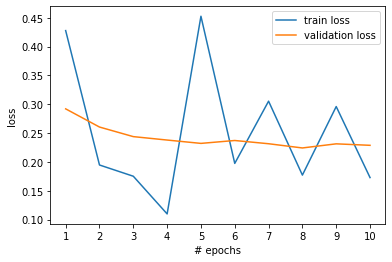

In [ ]:
plot(train_losses, val_losses)

In [ ]:
test_acc = inference(resnet50, test_loader)
print_acc(test_acc,train=False)

  0%|          | 0/94 [00:00<?, ?it/s]

Test Accuracy: 91.67%


## Finetuning ResNet50 

In [ ]:
resnet50_finetuned = torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2)

for name,param in resnet50_finetuned.named_parameters():
  if not 'layer4' in name:
    param.requires_grad = False

resnet50_finetuned.fc = nn.Linear(2048,num_classes)
resnet50_finetuned.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
params_to_update = []
for name,param in resnet50_finetuned.named_parameters():
        if param.requires_grad == True:
          params_to_update.append(param)
          print(name)

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.conv3.weight
layer4.0.bn3.weight
layer4.0.bn3.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.1.conv3.weight
layer4.1.bn3.weight
layer4.1.bn3.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.weight
fc.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update,lr = 0.001)

In [ ]:
train_losses, val_losses = training(resnet50_finetuned,train_loader,test_loader,criterion ,optimizer,epochs= 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.62, Validation Loss: 0.21


Epoch 2:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.36, Validation Loss: 0.21


Epoch 3:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.25, Validation Loss: 0.22


Epoch 4:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.21, Validation Loss: 0.22


Epoch 5:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.20, Validation Loss: 0.23


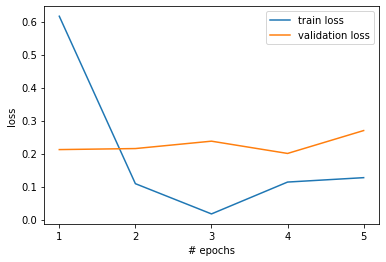

In [ ]:
plot(train_losses, val_losses)

In [ ]:
test_acc = inference(resnet50_finetuned, test_loader)
print_acc(test_acc)

  0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 92.87%


## Densenet201 with finetuning

In [ ]:
densenet = torchvision.models.densenet201(weights = torchvision.models.DenseNet201_Weights.IMAGENET1K_V1)

for name,param in densenet.named_parameters():
  if not 'denseblock4' in name:
      param.requires_grad = False
densenet.classifier = nn.Linear(1920,num_classes)
densenet.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
params_to_update = []
for name,param in densenet.named_parameters():
        if param.requires_grad == True:
          params_to_update.append(param)
          print(name)

features.denseblock4.denselayer1.norm1.weight
features.denseblock4.denselayer1.norm1.bias
features.denseblock4.denselayer1.conv1.weight
features.denseblock4.denselayer1.norm2.weight
features.denseblock4.denselayer1.norm2.bias
features.denseblock4.denselayer1.conv2.weight
features.denseblock4.denselayer2.norm1.weight
features.denseblock4.denselayer2.norm1.bias
features.denseblock4.denselayer2.conv1.weight
features.denseblock4.denselayer2.norm2.weight
features.denseblock4.denselayer2.norm2.bias
features.denseblock4.denselayer2.conv2.weight
features.denseblock4.denselayer3.norm1.weight
features.denseblock4.denselayer3.norm1.bias
features.denseblock4.denselayer3.conv1.weight
features.denseblock4.denselayer3.norm2.weight
features.denseblock4.denselayer3.norm2.bias
features.denseblock4.denselayer3.conv2.weight
features.denseblock4.denselayer4.norm1.weight
features.denseblock4.denselayer4.norm1.bias
features.denseblock4.denselayer4.conv1.weight
features.denseblock4.denselayer4.norm2.weight
fe

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update,lr = 0.001)

In [ ]:
train_losses, val_losses = training(densenet,train_loader,test_loader,criterion ,optimizer,epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.54, Validation Loss: 0.21


Epoch 2:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.41, Validation Loss: 0.19


Epoch 3:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.32, Validation Loss: 0.20


Epoch 4:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.29, Validation Loss: 0.20


Epoch 5:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.25, Validation Loss: 0.21


Epoch 6:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.27, Validation Loss: 0.21


Epoch 7:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.23, Validation Loss: 0.22


Epoch 8:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.20, Validation Loss: 0.22


Epoch 9:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.18, Validation Loss: 0.23


Epoch 10:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.17, Validation Loss: 0.24


Epoch 11:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.18, Validation Loss: 0.24


Epoch 12:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.16, Validation Loss: 0.25


Epoch 13:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.15, Validation Loss: 0.25


Epoch 14:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.15, Validation Loss: 0.26


Epoch 15:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.14, Validation Loss: 0.26


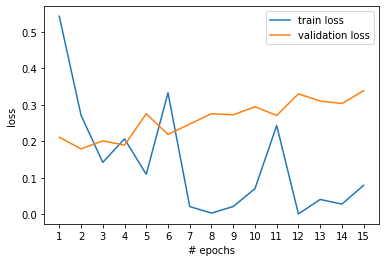

In [ ]:
plot(train_losses, val_losses)

In [ ]:
test_acc = inference(densenet, test_loader)
print_acc(test_acc)

  0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 93.13%


## ResNeXt50 with finetuning

In [ ]:
resnext = torchvision.models.resnext50_32x4d(weights = torchvision.models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
for name,param in resnext.named_parameters():
  if not 'layer4' in name:
    param.requires_grad = False

resnext.fc = nn.Linear(2048,num_classes)
resnext.to(device)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
params_to_update = []
for name,param in resnext.named_parameters():
        if param.requires_grad == True:
          params_to_update.append(param)
          print(name)

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.conv3.weight
layer4.0.bn3.weight
layer4.0.bn3.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.1.conv3.weight
layer4.1.bn3.weight
layer4.1.bn3.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.weight
fc.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update,lr = 0.001)

In [ ]:
train_losses, val_losses = training(resnext,train_loader,test_loader,criterion ,optimizer,epochs= 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.27, Validation Loss: 0.47


Epoch 2:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.28, Validation Loss: 0.36


Epoch 3:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.26, Validation Loss: 0.40


Epoch 4:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.32, Validation Loss: 0.57


Epoch 5:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.31, Validation Loss: 0.53


Epoch 6:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.26, Validation Loss: 0.49


Epoch 7:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.23, Validation Loss: 0.45


Epoch 8:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.22, Validation Loss: 0.44


Epoch 9:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.20, Validation Loss: 0.66


Epoch 10:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.19, Validation Loss: 0.65


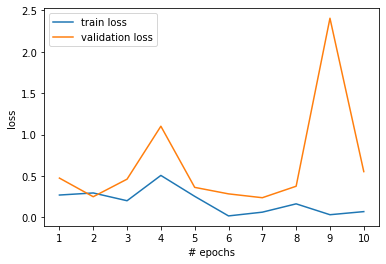

In [ ]:
plot(train_losses, val_losses)

In [ ]:
test_acc = inference(resnext, test_loader)
print_acc(test_acc)

  0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 92.77%


## Vision Transformer

In [ ]:

BATCH_SIZE = 64

train_loader = DataLoader(dataset = train_ds,batch_size = BATCH_SIZE,shuffle = True,num_workers=2,pin_memory=True)
test_loader = DataLoader(dataset = test_ds,batch_size = BATCH_SIZE,num_workers=2, pin_memory=True)

In [ ]:
vit = torchvision.models.vit_b_16(weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1)
for param in vit.parameters():
    param.requires_grad = False

vit.heads = nn.Linear(768,num_classes)
vit.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
params_to_update = []
for name,param in vit.named_parameters():
        if param.requires_grad == True:
          params_to_update.append(param)
          print(name)

heads.weight
heads.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update,lr = 0.001)

In [ ]:
train_losses, val_losses = training(vit,train_loader,test_loader,criterion ,optimizer,epochs= 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 0.09, Validation Loss: 0.16


Epoch 2:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 0.06, Validation Loss: 0.16


Epoch 3:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 0.09, Validation Loss: 0.15


Epoch 4:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 0.13, Validation Loss: 0.15


Epoch 5:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 0.12, Validation Loss: 0.15


In [ ]:
test_acc = inference(vit, test_loader)
print_acc(test_acc,False)

  0%|          | 0/47 [00:00<?, ?it/s]

Test Accuracy: 94.90%
